# Análise de Churn no E-commerce Brasileiro (Olist)

In [1]:
# Importando as Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Carregando os dados
orders = pd.read_csv("dataset/olist_orders_dataset.csv")
products = pd.read_csv("dataset/olist_products_dataset.csv")
customers = pd.read_csv('dataset/olist_customers_dataset.csv')
order_items = pd.read_csv('dataset/olist_order_items_dataset.csv')
reviews = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
payments = pd.read_csv('dataset/olist_order_payments_dataset.csv')

# Limpeza dos dados

In [3]:
# Alterando strings para datas
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [4]:
# Verificando dados ausentes
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [5]:
# Selecionando somente os pedidos que foram entregues
orders = orders[orders['order_status'] == 'delivered']

In [6]:
orders = orders.dropna(subset=[
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date'
])

orders.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [7]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [8]:
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [9]:
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [10]:
# Exluindo a coluna "review_comment_title" e "review_comment_message", pois para essa análise não serão utilizadas
reviews = reviews.drop(columns=['review_comment_title', 'review_comment_message'])
reviews.isnull().sum()

review_id                  0
order_id                   0
review_score               0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

In [11]:
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [12]:
# Preencher valores faltantes com a mediana
products['product_weight_g'] = products['product_weight_g'].fillna(products['product_weight_g'].median())
products['product_length_cm'] = products['product_length_cm'].fillna(products['product_length_cm'].median())
products['product_height_cm'] = products['product_height_cm'].fillna(products['product_height_cm'].median())
products['product_width_cm'] = products['product_width_cm'].fillna(products['product_width_cm'].median())
products['product_name_lenght'] = products['product_name_lenght'].fillna(products['product_name_lenght'].median())
products['product_description_lenght'] = products['product_description_lenght'].fillna(products['product_description_lenght'].median())
products['product_photos_qty'] = products['product_photos_qty'].fillna(products['product_photos_qty'].median())

# Substituindo as categorias faltantes para "desconhecido"
products['product_category_name'] = products['product_category_name'].fillna('desconhecido')

products.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [13]:
payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

# Criando o DataFrame

In [14]:
# Unindo pedidos e clientes 
df = pd.merge(orders, customers, on='customer_id', how='left')
df = pd.merge(df, payments, on='order_id', how='left')
df = pd.merge(df, reviews[['order_id', 'review_score']], on='order_id', how='left')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101303 entries, 0 to 101302
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       101303 non-null  object        
 1   customer_id                    101303 non-null  object        
 2   order_status                   101303 non-null  object        
 3   order_purchase_timestamp       101303 non-null  datetime64[ns]
 4   order_approved_at              101303 non-null  datetime64[ns]
 5   order_delivered_carrier_date   101303 non-null  datetime64[ns]
 6   order_delivered_customer_date  101303 non-null  datetime64[ns]
 7   order_estimated_delivery_date  101303 non-null  datetime64[ns]
 8   customer_unique_id             101303 non-null  object        
 9   customer_zip_code_prefix       101303 non-null  int64         
 10  customer_city                  101303 non-null  object        
 11  

In [16]:
print(df.duplicated().sum())

360


In [17]:
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

0


In [18]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_score'],
      dtype='object')

# Feature Engineering

In [19]:
# Número total de pedidos por cliente
pedidos_por_cliente = (
    df
    .groupby('customer_unique_id')['order_id']
    .nunique()
)

In [20]:
# Última data de compra por cliente
compra_cliente = df.groupby('customer_unique_id').agg({'order_purchase_timestamp': ['min', 'max', 'count']}).reset_index()
compra_cliente.columns = ['customer_unique_id', 'primeira_compra', 'ultima_compra', 'qtde_pedidos']

In [21]:
# Tempo entre o primeiro e o último pedido
data_final = df['order_purchase_timestamp'].max()
compra_cliente['dias_desde_ultima_compra'] = (data_final - compra_cliente['ultima_compra']).dt.days

In [23]:
# Frequência média de compra

In [24]:
# Valor total gasto

In [25]:
# Nota média de avaliação

# Cálculo do Churn

In [26]:
# Definindo quais clientes não pediu nos últimos 180 dias
compra_cliente['churn'] = compra_cliente['dias_desde_ultima_compra'].apply(lambda x: 1 if x > 180 else 0)

In [32]:
taxa_churn = compra_cliente['churn'].mean()
print(f"Taxa de Churn: {taxa_churn:.2%}")

Taxa de Churn: 58.92%


In [ ]:
# Distribuição do churn por:
# Região geográfica.



In [ ]:
# Categoria de produto.

In [ ]:
# Valor gasto.


In [ ]:
# Tempo de entrega.


# Análise Gráfica

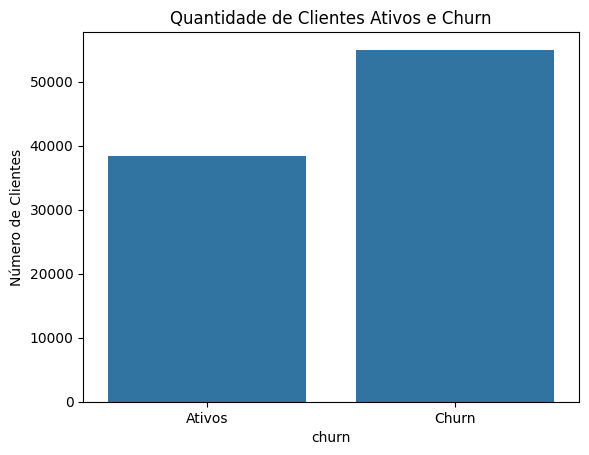

In [27]:
# Quantidade de clientes ativos e Churn
sns.countplot(x='churn', data=compra_cliente)
plt.title('Quantidade de Clientes Ativos e Churn')
plt.xticks([0, 1], ['Ativos', 'Churn'])
plt.ylabel('Número de Clientes')
plt.show()

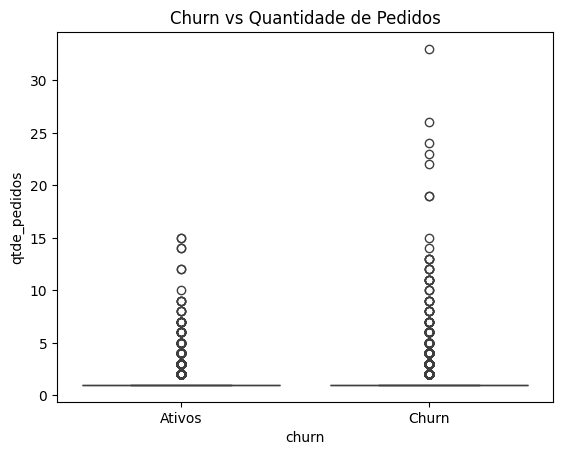

In [28]:
# Quantidade de pedidos e churn
sns.boxplot(x='churn', y='qtde_pedidos', data=compra_cliente)
plt.title('Churn vs Quantidade de Pedidos')
plt.xticks([0, 1], ['Ativos', 'Churn'])
plt.show()